# Generate sample from 1D GZ with Euler-Maruyama

Saved data at iteration 0, total violation is 0
Saved data at iteration 1, total violation is 0
Saved data at iteration 2, total violation is 0
Saved data at iteration 3, total violation is 0
Saved data at iteration 4, total violation is 0
Saved data at iteration 5, total violation is 0
Saved data at iteration 6, total violation is 0
Saved data at iteration 7, total violation is 0
Saved data at iteration 8, total violation is 0
Saved data at iteration 9, total violation is 0
Saved data at iteration 10, total violation is 0
Saved data at iteration 11, total violation is 0
Saved data at iteration 12, total violation is 0
Saved data at iteration 13, total violation is 0
Saved data at iteration 14, total violation is 0
Saved data at iteration 15, total violation is 0
Saved data at iteration 16, total violation is 0
Saved data at iteration 17, total violation is 0
Saved data at iteration 18, total violation is 0
Saved data at iteration 19, total violation is 0
Saved data at iteration 20, to

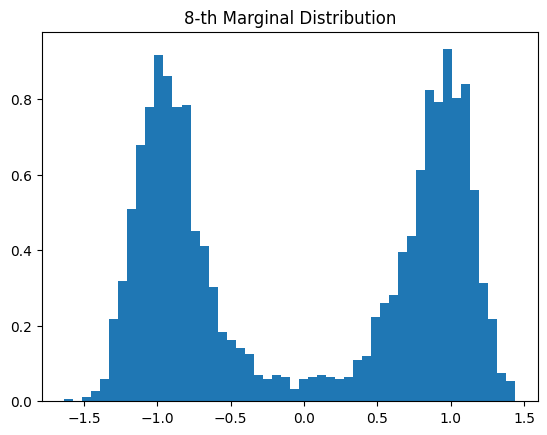

In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Given constants
d = 16
h = 1 / (d + 1)
λ = 0.01
β = 2

T = 1
scale = 80 # 150 for d = 64
dt = 0.0005 * scale / β
N = int(T*scale/dt)  # Interested in T = 1
dt = T*scale/N  # Correct for small deviation

l_MALA = True

BATCH_SIZE = 100  # Set your desired batch size

data_path = f"./Saved_Data/1D_GZ_data_d_{d}.npz"

# Hyperparameters
hyperparameters = {
    "d": d,
    "h": h,
    "λ": λ,
    "β": β,
    "dt": dt,
    "N": N,
    "BATCH_SIZE": BATCH_SIZE
}

# # Create directory if it doesn't exist
# if not os.path.exists("./Saved_Data"):
#     os.makedirs("./Saved_Data")

# # Load existing data or initialize
# if os.path.exists(data_path):
#     with np.load(data_path) as data:
#         all_samples = data['samples']
# else:
#     all_samples = np.empty((0, d + 2))

if os.path.exists(data_path):
    os.remove(data_path)

all_samples = np.empty((0, d + 2))

def V(U):
    # potential energy V
    dim1 = U.shape[0]
    U = np.concatenate((np.zeros((dim1,1)), U, np.zeros((dim1,1))), axis=1)
    return β / d * ( λ/h**2/2 * np.sum((U - np.roll(U, 1, axis = 1))**2, axis = 1) + np.sum(((1 - U**2)**2)[:, 1:-1], axis = 1) /4/λ )

def V_grad(U):
    # Gradient of the potential energy V
    dim1 = U.shape[0]
    U = np.concatenate((np.zeros((dim1,1)), U, np.zeros((dim1,1))), axis=1)
    return β / d * ( λ/h**2 * (2*U - np.roll(U, 1, axis = 1) - np.roll(U, -1, axis = 1)) - U * (1 - U**2) /λ ) [:, 1:-1]

def Langevin_step(U,V,V_grad,l_MALA=True):
    dW = np.sqrt(dt) * np.random.randn(BATCH_SIZE, d)
    
    U_tmp = U.copy()
    U_tmp += (-V_grad(U_tmp) * dt + np.sqrt(2) * dW)

    count = np.sum(U_tmp > 2.5) + np.sum(U_tmp <-2.5)
    U_tmp[U_tmp > 2.5] = 2.5
    U_tmp[U_tmp < -2.5] = -2.5

    if l_MALA:
        log_acceptance_ratio = np.minimum(0.0, - (V(U_tmp) - V(U)) \
                                      - 1/4/dt * (np.sum(((U - U_tmp + dt * V_grad(U_tmp)))**2,axis=1) \
                                                      - np.sum(((U_tmp - U + dt * V_grad(U)))**2,axis=1)))
        # Accept or reject
        accept = np.log(np.random.uniform(size=U.shape[0])) < log_acceptance_ratio

        # print(np.sum(accept))
    
        return np.where(accept[:, None], U_tmp, U), count
    else:
        return U_tmp, count

count = 0

for iteration in range(30):

    # U = np.zeros((BATCH_SIZE, d))  # Initialize at each iteration
    U = np.ones((BATCH_SIZE, d))  # Initialize at each iteration

    # Creating samples for 1D Ginzburg Landau
    for _ in range(N):
        U, count_ = Langevin_step(U,V,V_grad,l_MALA)
        count += count_

    dim1 = U.shape[0]
    U = np.concatenate((np.zeros((dim1,1)), U, np.zeros((dim1,1))), axis=1)
    
    all_samples = np.concatenate((all_samples, U), axis=0)
    print(f'Saved data at iteration {iteration}, total violation is {count}')

    # Save the accumulated data
    np.savez(data_path, samples=all_samples, hyperparameters=hyperparameters)

print(f'total number of violation is {count}')

# Visualization of the (d/2)-th marginal distribution
samples_1_mar = all_samples[:, round(d/2)]  # Extract the d/2-th bit from each sample
plt.hist(samples_1_mar, bins=50, density=True)
plt.title(f"{round(d/2)}-th Marginal Distribution")
# plt.savefig('test2.png',bbox_inches='tight')
plt.show()
